<a href="https://colab.research.google.com/github/bala2tech/Digital-Twin-Predictive-Quality-Monitoring-System/blob/main/Digital_Twin_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta
import random

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import gradio as gr

# For reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)


In [2]:
def simulate_machine_data(
    n_machines=10,
    days=60,
    records_per_day=24  # hourly
):
    rows = []
    start_time = datetime(2025, 1, 1)

    for m in range(1, n_machines + 1):
        machine_id = f"M{m:02d}"

        # Base behaviour per machine (slightly different per machine)
        base_temp = np.random.uniform(60, 80)
        base_vib = np.random.uniform(0.5, 1.5)
        base_press = np.random.uniform(4, 8)
        base_speed = np.random.uniform(1500, 2500)

        tool_wear = 0.0

        for d in range(days * records_per_day):
            ts = start_time + timedelta(hours=d)

            # Simulate drift & noise
            temp = base_temp + np.random.normal(0, 2) + 0.03 * (d / records_per_day)
            vib = base_vib + np.random.normal(0, 0.1) + 0.005 * (d / records_per_day)
            press = base_press + np.random.normal(0, 0.2)
            speed = base_speed + np.random.normal(0, 50)
            tool_wear += np.random.uniform(0.01, 0.1)  # cumulative

            # Simple rule-based true risk (for labeling)
            quality_risk_rule = (
                (temp > 85) or
                (vib > 2.0) or
                (tool_wear > 50) or
                ((press < 4.0) or (press > 9.0))
            )

            failure_rule = (
                (temp > 90 and vib > 2.2) or
                (tool_wear > 70)
            )

            quality_ok = 0 if quality_risk_rule else 1
            failure = 1 if failure_rule else 0

            rows.append({
                "machine_id": machine_id,
                "timestamp": ts,
                "temperature": round(temp, 2),
                "vibration": round(vib, 3),
                "pressure": round(press, 2),
                "speed": round(speed, 1),
                "tool_wear": round(tool_wear, 2),
                "quality_ok": quality_ok,
                "failure": failure
            })

    return pd.DataFrame(rows)

data = simulate_machine_data()
data.head()


,machine_id,timestamp,temperature,vibration,pressure,speed,tool_wear,quality_ok,failure
0,M01,2025-01-01 00:00:00,67.02,1.427,7.24,2137.0,0.01,1,0
1,M01,2025-01-01 01:00:00,66.33,1.398,6.81,2052.5,0.07,1,0
2,M01,2025-01-01 02:00:00,64.04,1.395,6.73,2114.4,0.11,1,0
3,M01,2025-01-01 03:00:00,66.09,1.237,6.80,2128.5,0.16,1,0
4,M01,2025-01-01 04:00:00,66.41,1.463,6.70,2117.4,0.18,1,0


In [3]:
print("Shape:", data.shape)
print(data.head())

print("\nQuality OK value counts:")
print(data["quality_ok"].value_counts())

print("\nFailure value counts:")
print(data["failure"].value_counts())

# Create target: 1 = at risk (bad quality or failure), 0 = healthy
data["quality_risk"] = np.where((data["quality_ok"] == 0) | (data["failure"] == 1), 1, 0)

print("\nQuality Risk value counts:")
print(data["quality_risk"].value_counts())


Shape: (14400, 9)
  machine_id           timestamp  temperature  vibration  pressure   speed  \
0        M01 2025-01-01 00:00:00        67.02      1.427      7.24  2137.0   
1        M01 2025-01-01 01:00:00        66.33      1.398      6.81  2052.5   
2        M01 2025-01-01 02:00:00        64.04      1.395      6.73  2114.4   
3        M01 2025-01-01 03:00:00        66.09      1.237      6.80  2128.5   
4        M01 2025-01-01 04:00:00        66.41      1.463      6.70  2117.4   

   tool_wear  quality_ok  failure  
0       0.01           1        0  
1       0.07           1        0  
2       0.11           1        0  
3       0.16           1        0  
4       0.18           1        0  

Quality OK value counts:
quality_ok
1    8801
0    5599
Name: count, dtype: int64

Failure value counts:
failure
0    12676
1     1724
Name: count, dtype: int64

Quality Risk value counts:
quality_risk
0    8801
1    5599
Name: count, dtype: int64


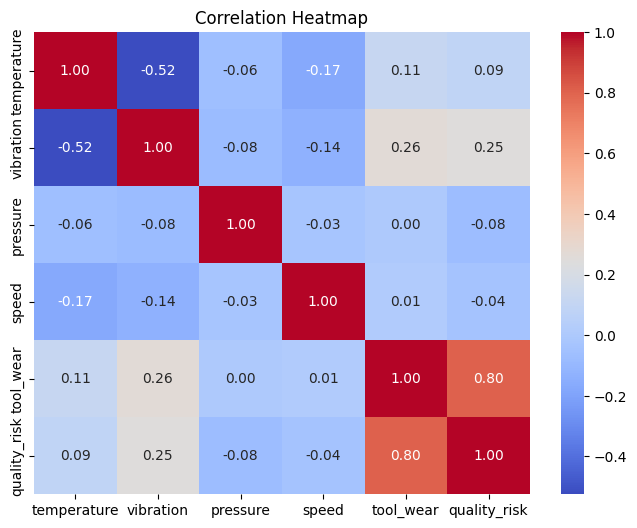

In [4]:
numeric_cols = ["temperature", "vibration", "pressure", "speed", "tool_wear", "quality_risk"]
plt.figure(figsize=(8, 6))
sns.heatmap(data[numeric_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


In [5]:
feature_cols = ["temperature", "vibration", "pressure", "speed", "tool_wear"]
X = data[feature_cols]
y = data["quality_risk"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

X_train.shape, X_test.shape


((11520, 5), (2880, 5))

In [6]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=SEED,
    class_weight="balanced"
)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC: {auc:.4f}")


Classification Report:
              precision    recall  f1-score   support

           0     0.9989    1.0000    0.9994      1760
           1     1.0000    0.9982    0.9991      1120

    accuracy                         0.9993      2880
   macro avg     0.9994    0.9991    0.9993      2880
weighted avg     0.9993    0.9993    0.9993      2880

Confusion Matrix:
[[1760    0]
 [   2 1118]]
ROC-AUC: 1.0000


In [7]:
importances = rf_model.feature_importances_
feat_imp = pd.DataFrame({"feature": feature_cols, "importance": importances})
feat_imp.sort_values("importance", ascending=False, inplace=True)
feat_imp


,feature,importance
4,tool_wear,0.888332
2,pressure,0.060597
1,vibration,0.032924
0,temperature,0.010251
3,speed,0.007896


In [8]:
def assess_machine_health(temperature, vibration, pressure, speed, tool_wear):
    """
    Use trained model + simple rules to assess risk and recommend actions.
    """
    # Create DataFrame for model
    X_input = pd.DataFrame([{
        "temperature": temperature,
        "vibration": vibration,
        "pressure": pressure,
        "speed": speed,
        "tool_wear": tool_wear
    }])

    risk_prob = rf_model.predict_proba(X_input)[0, 1]
    risk_label = "AT RISK" if risk_prob >= 0.5 else "HEALTHY"

    # Simple rule-based recommendations
    recommendations = []

    if temperature > 85:
        recommendations.append("Reduce temperature: check coolant flow / lubrication.")
    if vibration > 2.0:
        recommendations.append("High vibration: check alignment, bearing condition, and imbalance.")
    if pressure < 4.0 or pressure > 9.0:
        recommendations.append("Abnormal pressure: inspect valves, pump, or leaks.")
    if tool_wear > 50:
        recommendations.append("Tool wear high: schedule tool change / regrinding soon.")
    if speed > 2600:
        recommendations.append("High spindle speed: verify cutting parameters and material compatibility.")

    if not recommendations:
        recommendations.append("Machine operating within normal limits. Continue monitoring.")

    return risk_label, float(risk_prob), recommendations

# Quick test
test_label, test_prob, test_reco = assess_machine_health(
    temperature=90, vibration=2.3, pressure=3.8, speed=2700, tool_wear=60
)
print("Status:", test_label)
print("Risk probability:", test_prob)
print("Recommendations:", test_reco)


Status: AT RISK
Risk probability: 1.0
Recommendations: ['Reduce temperature: check coolant flow / lubrication.', 'High vibration: check alignment, bearing condition, and imbalance.', 'Abnormal pressure: inspect valves, pump, or leaks.', 'Tool wear high: schedule tool change / regrinding soon.', 'High spindle speed: verify cutting parameters and material compatibility.']


In [35]:
def gradio_predict(
    temperature,
    vibration,
    pressure,
    speed,
    tool_wear
):
    status, risk_prob, recommendations = assess_machine_health(
        temperature, vibration, pressure, speed, tool_wear
    )

    rec_text = "\n".join([f"- {r}" for r in recommendations])

    # Return values in the same order as outputs: status, prob, text
    return status, f"{risk_prob:.3f}", rec_text


with gr.Blocks() as demo:
    gr.Markdown("# 🏭 Digital Twin – Predictive Quality Monitoring System")
    gr.Markdown(
        "Enter live machine parameters to estimate quality/failure risk and get recommended actions."
    )

    with gr.Row():
        with gr.Column():
            temp_in = gr.Slider(50, 110, value=75, step=0.5, label="Temperature (°C)")
            vib_in = gr.Slider(0.2, 3.0, value=1.0, step=0.01, label="Vibration (mm/s)")
            press_in = gr.Slider(3.0, 10.0, value=6.0, step=0.1, label="Pressure (bar)")
            speed_in = gr.Slider(1000, 3000, value=2000, step=50, label="Spindle Speed (RPM)")
            wear_in = gr.Slider(0, 100, value=20, step=1, label="Tool Wear Index")

            btn = gr.Button("Assess Machine Health")

        with gr.Column():
            status_out = gr.Label(label="Status (Healthy / At Risk)")
            prob_out = gr.Label(label="Risk Probability")
            reco_out = gr.Textbox(label="Recommended Actions", lines=6)

    btn.click(
        fn=gradio_predict,
        inputs=[temp_in, vib_in, press_in, speed_in, wear_in],
        outputs=[status_out, prob_out, reco_out]
    )

demo.launch(debug=True)


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://8f14bd88ec2e82e141.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://8f14bd88ec2e82e141.gradio.live


In [39]:
def gradio_predict(temperature, vibration, pressure, speed, tool_wear):
    status, risk_prob, recommendations = assess_machine_health(
        temperature, vibration, pressure, speed, tool_wear
    )

    # Send alert only if machine is at risk
    if status == "AT RISK":
        send_easy_email_alert(status, risk_prob, recommendations)
        beep_alert() # Call beep_alert when status is 'AT RISK'

    rec_text = "\n".join([f"- {r}" for r in recommendations])

    return status, f"{risk_prob:.3f}", rec_text

In [40]:
def beep_alert():
    print("\a")  # system beep sound
    print("⚠️ ALERT: Machine At Risk!")


In [29]:
# The code was moved to gradio_predict function to resolve the NameError.